# Episode plots

In [1]:
from huggingface_hub import hf_hub_download, HfApi
from plotnine import ggplot, aes, geom_point, geom_line, ggtitle, scale_color_manual, ylim
from skopt import load
from stable_baselines3 import PPO

from rl4fisheries import AsmEnv, FMsy, ConstantEscapement, PrecautionaryPrinciple
from rl4fisheries.utils import evaluate_agent
from rl4fisheries.envs.asm_fns import get_r_devs_logn_unif

import numpy as np
import pandas as pd
import ray

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
PLOT_T_MAX = 300 # plot only 300 timesteps for easier visuals

## UM1

CFG_UM1_2o = {
    'observation_fn_id': 'observe_2o',
    'n_observs': 2,
    'obs_noise': 0.1,
    #
    'harvest_fn_name': "default",
    'upow': 1,
}
CFG_UM1_bm = {
    'observation_fn_id': 'observe_1o',
    'n_observs': 1,
    'obs_noise': 0.1,
    #
    'harvest_fn_name': "default",
    'upow': 1,
}

## UM2

CFG_UM2_2o = {
    'observation_fn_id': 'observe_2o',
    'n_observs': 2,
    'obs_noise': 0.1,
    #
    'harvest_fn_name': "default",
    'upow': 0.6,
}
CFG_UM2_bm = {
    'observation_fn_id': 'observe_1o',
    'n_observs': 1,
    'obs_noise': 0.1,
    #
    'harvest_fn_name': "default",
    'upow': 0.6,
}

## UM3

CFG_UM3_2o = {
    'observation_fn_id': 'observe_2o',
    'n_observs': 2,
    'obs_noise': 0.1,
    #
    'harvest_fn_name': "trophy",
    'upow': 1,
    'n_trophy_ages': 10
}
CFG_UM3_bm = {
    'observation_fn_id': 'observe_1o',
    'n_observs': 1,
    'obs_noise': 0.1,
    #
    'harvest_fn_name': "trophy",
    'upow': 1,
    'n_trophy_ages': 10
}


## Load

In [3]:
cr_UM1_file = hf_hub_download(repo_id="boettiger-lab/rl4eco", filename="sb3/rl4fisheries/post-review-results/cr-UM1-noise01.pkl")
cr_UM2_file = hf_hub_download(repo_id="boettiger-lab/rl4eco", filename="sb3/rl4fisheries/post-review-results/cr-UM2-noise01.pkl")
cr_UM3_file = hf_hub_download(repo_id="boettiger-lab/rl4eco", filename="sb3/rl4fisheries/post-review-results/cr-UM3-noise01.pkl")

msy_UM1_file = hf_hub_download(repo_id="boettiger-lab/rl4eco", filename="sb3/rl4fisheries/post-review-results/msy-UM1-noise01.pkl")
msy_UM2_file = hf_hub_download(repo_id="boettiger-lab/rl4eco", filename="sb3/rl4fisheries/post-review-results/msy-UM2-noise01.pkl")
msy_UM3_file = hf_hub_download(repo_id="boettiger-lab/rl4eco", filename="sb3/rl4fisheries/post-review-results/msy-UM3-noise01.pkl")

In [4]:
cr_UM1 = load(cr_UM1_file)
cr_UM2 = load(cr_UM2_file)
cr_UM3 = load(cr_UM3_file)

msy_UM1 = load(msy_UM1_file)
msy_UM2 = load(msy_UM2_file)
msy_UM3 = load(msy_UM3_file)

In [5]:
base_fname = "sb3/rl4fisheries/post-review-results/PPO-AsmEnv-"
repo = "boettiger-lab/rl4eco"

PPO_2o_UM1_file = hf_hub_download(repo_id=repo, filename=base_fname+"2obs-UM1-256-64-16-noise0.1-chkpnt2.zip")
PPO_bm_UM1_file = hf_hub_download(repo_id=repo, filename=base_fname+"biomass-UM1-64-32-16-noise0.1-chkpnt2.zip")

PPO_2o_UM2_file = hf_hub_download(repo_id=repo, filename=base_fname+"2obs-UM2-256-64-16-noise0.1-chkpnt4.zip")
PPO_bm_UM2_file = hf_hub_download(repo_id=repo, filename=base_fname+"biomass-UM2-64-32-16-noise0.1-chkpnt4.zip")

PPO_2o_UM3_file = hf_hub_download(repo_id=repo, filename=base_fname+"2obs-UM3-256-64-16-noise0.1-chkpnt2.zip")
PPO_bm_UM3_file = hf_hub_download(repo_id=repo, filename=base_fname+"biomass-UM3-64-32-16-noise0.1-chkpnt4.zip")



In [6]:

fmsy_UM1 = msy_UM1.x[0]
fmsy_UM2 = msy_UM2.x[0]
fmsy_UM3 = msy_UM3.x[0]

msy_rew_UM1 = -msy_UM1.fun
msy_rew_UM2 = -msy_UM2.fun
msy_rew_UM3 = -msy_UM3.fun

fmsy_avg_rewards = {
    'um1': msy_rew_UM1/1000,
    'um2': msy_rew_UM2/1000,
    'um3': msy_rew_UM3/1000,
}

fmsy_vals = {
    'um1': fmsy_UM1,
    'um2': fmsy_UM2,
    'um3': fmsy_UM3,
}

bmsy = fmsy_avg_rewards['um1'] / fmsy_vals['um1'] 


def get_dfo_pol(fmsy, bmsy, env_cfg):
    return PrecautionaryPrinciple(
        env = AsmEnv(config=env_cfg),
        x1 = 0.4 * bmsy,
        x2 = 0.8 * bmsy,
        y2 = fmsy,
    )

In [7]:
PPO_2o_UM1 = PPO.load(PPO_2o_UM1_file, device='cpu')
PPO_bm_UM1 = PPO.load(PPO_bm_UM1_file, device='cpu')

PPO_2o_UM2 = PPO.load(PPO_2o_UM2_file, device='cpu')
PPO_bm_UM2 = PPO.load(PPO_bm_UM2_file, device='cpu')

PPO_2o_UM3 = PPO.load(PPO_2o_UM3_file, device='cpu')
PPO_bm_UM3 = PPO.load(PPO_bm_UM3_file, device='cpu')

## Utilities

Use 2 observations for all agents! (It's ok, they'll only use the first observation - biomass - but, the plots will also keep track of the mean weight (the second observation.)

In [8]:
def obs_to_mwt(obs, env):
    return env.parameters['min_wt'] + (
        env.parameters['max_wt'] - env.parameters['min_wt']
    ) * (obs + 1) / 2

def obs_to_bms(obs, env):
    return env.bound * (obs + 1) / 2

def safe_predict(agent, obs, observed_var):
    if observed_var == '2o':
        if len(obs) == 2:
            return agent.predict(obs)
    if observed_var == 'mw':
        if len(obs) == 2:
            return agent.predict(np.float32([obs[1]]))
        if len(obs) == 1:
            return agent.predict(obs)
    if observed_var == 'bm':
        if len(obs) == 2:
            # print(obs[0], agent.predict(np.float32([obs[0]]))) ###########
            return agent.predict(np.float32([obs[0]]))
        if len(obs) == 1:
            return agent.predict(obs)
    print(f'problem in safe_predict. obs: {obs}, observed_var: {observed_var}')
    return

def simulate_episode(*, env, agent, observed_var: 'bm, mw or 2o'):
    bms = []
    mwt = []
    ts = []
    fishing = []
    rews = []
    obs, _ = env.reset()
    #
    for t in range(env.Tmax):
        action, info = safe_predict(agent, obs, observed_var) # agent.predict(obs)
        # print(obs, action, end="\n\n")
        new_obs, rew, term, trunc, info = env.step(action)
        #
        bms.append(obs_to_bms(obs=obs[0], env=env))
        mwt.append(obs_to_mwt(obs=obs[1], env=env))
        ts.append(t)
        fishing.append(0.5 * (1 + action[0]))
        rews.append(rew)
        obs = new_obs
        if term or trunc:
            break
    return {
        't': ts,
        'biomass': bms,
        'mean_wt': mwt,
        'fishing_intensity': fishing,
        'rew': rews,
    }
    
def from_radius_theta(radius, theta, y2):
    x1 = radius * np.sin(theta)
    x2 = radius * np.cos(theta)
    return {'x1': x1, 'x2': x2, 'y2': y2}  

def ggplot_preprocess(df, max_t=400):
    """
    df:
    t | biomass | mean_wt | fishing_intensity

    out df:
    1. limit t to max_t
    2. make long
    """
    return (
        df[df.t < max_t].melt(id_vars = ['t'], value_vars = ['biomass', 'mean_wt']),
        df[df.t < max_t].melt(id_vars = ['t'], value_vars = ['fishing_intensity']),
        
    )

## Reproducible noise env

In [9]:
r_devs = get_r_devs_logn_unif(n_year=AsmEnv().Tmax)

env_UM1 = AsmEnv(
    config = {**CFG_UM1_2o, 'reproducibility_mode': True, 'r_devs': r_devs}
)

env_UM2 = AsmEnv(
    config = {**CFG_UM2_2o, 'reproducibility_mode': True, 'r_devs': r_devs}
)

env_UM3 = AsmEnv(
    config = {**CFG_UM3_2o, 'reproducibility_mode': True, 'r_devs': r_devs}
)

0 0 18 921 948 52


<Axes: xlabel='t'>

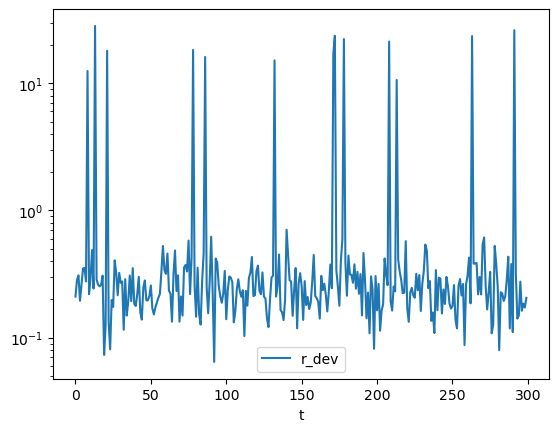

In [10]:
rdev_df = pd.DataFrame({'r_dev': r_devs, 't': list(range(len(r_devs)))})
print(
    rdev_df[rdev_df.r_dev < 0.0001].r_dev.count(),
    rdev_df[rdev_df.r_dev < 0.01].r_dev.count(),
    rdev_df[rdev_df.r_dev < 0.1].r_dev.count(),
    rdev_df[rdev_df.r_dev < 0.5].r_dev.count(),
    rdev_df[rdev_df.r_dev < 1].r_dev.count(),
    rdev_df[rdev_df.r_dev > 10].r_dev.count(),
)
rdev_df[rdev_df.t < PLOT_T_MAX].plot(x='t', logy=True)

## UM1

Caution: sometimes PPO_bm_UM1 seems to go out of wack and start predicting a constant action. This is not the behavior that it's supposed to have and the value of the constant action can be quite erratic (usually leading to near-zero rewards, inconsistent with notebook 2). If this happens, usually re-loading the model fixes the problem. Not really sure where the bug is coming from ATM.

In [11]:
ppo_bm_UM1_ep = pd.DataFrame(simulate_episode(env=env_UM1, agent=PPO_bm_UM1, observed_var='bm'))
ppo_2o_UM1_ep = pd.DataFrame(simulate_episode(env=env_UM1, agent=PPO_2o_UM1, observed_var='2o'))

cr_UM1_ep = pd.DataFrame(simulate_episode(
    env = env_UM1, 
    agent = PrecautionaryPrinciple(
            env = env_UM1,
            **(from_radius_theta(*cr_UM1.x)), 
        ), 
    observed_var='bm',
))

dfo_UM1_ep = pd.DataFrame(simulate_episode(
    env = env_UM1, 
    agent = get_dfo_pol(fmsy=fmsy_vals['um1'], bmsy=bmsy, env_cfg=CFG_UM1_bm), 
    observed_var='bm',
))

msy_UM1_ep = pd.DataFrame(simulate_episode(
    env = env_UM1, 
    agent = FMsy(
            env = env_UM1,
            mortality=msy_UM1.x[0], 
        ), 
    observed_var='bm',
))

In [12]:
prep_ep = ggplot_preprocess(cr_UM1_ep)
geom_line.DEFAULT_AES['size']=1
# (
#     ggplot(
#         prep_ep[0],
#         aes(x='t', y='value', color='variable')
#     )
#     + geom_line()
#     + scale_color_manual(values=['green', 'black', 'orange'])
# ).save('plots/episodes/um1-cr')

In [13]:
max_t = PLOT_T_MAX

ppo_2o_UM1_ep_melted_duplet = ggplot_preprocess(ppo_2o_UM1_ep)
ppo_bm_UM1_ep_melted_duplet = ggplot_preprocess(ppo_bm_UM1_ep)

cr_UM1_ep_melted_duplet = ggplot_preprocess(cr_UM1_ep)
msy_UM1_ep_melted_duplet = ggplot_preprocess(msy_UM1_ep)
dfo_UM1_ep_melted_duplet = ggplot_preprocess(dfo_UM1_ep)

(
    (
        ggplot(
            ppo_2o_UM1_ep_melted_duplet[0],
            aes(x='t', y='value', color='variable')
        )
        + geom_line()
        + scale_color_manual(values=['green', 'orange'])
        + ggtitle('UM1 ppo 2o')
    ).save('plots/episodes/um1-2ppo-obs'),
    (
        ggplot(
            ppo_2o_UM1_ep_melted_duplet[1],
            aes(x='t', y='value', color='variable')
        )
        + geom_line()
        + scale_color_manual(values=['black'])
        + ggtitle('UM1 ppo 2o')
        + ylim(0,1)
    ).save('plots/episodes/um1-2ppo-act'),
    #
    (
        ggplot(
            ppo_bm_UM1_ep_melted_duplet[0],
            aes(x='t', y='value', color='variable')
        )
        + geom_line()
        + scale_color_manual(values=['green', 'orange'])
        + ggtitle('UM1 ppo 1o')
    ).save('plots/episodes/um1-1ppo-obs'),
    (
        ggplot(
            ppo_bm_UM1_ep_melted_duplet[1],
            aes(x='t', y='value', color='variable')
        )
        + geom_line()
        + scale_color_manual(values=['black'])
        + ggtitle('UM1 ppo 1o')
        + ylim(0,1)
    ).save('plots/episodes/um1-1ppo-act'),
    #
    (
        ggplot(
            cr_UM1_ep_melted_duplet[0],
            aes(x='t', y='value', color='variable')
        )
        + geom_line()
        + scale_color_manual(values=['green', 'orange'])
        + ggtitle('UM1 CR')
    ).save('plots/episodes/um1-cr-obs'),
    (
        ggplot(
            cr_UM1_ep_melted_duplet[1],
            aes(x='t', y='value', color='variable')
        )
        + geom_line()
        + scale_color_manual(values=['black'])
        + ggtitle('UM1 CR')
        + ylim(0,1)
    ).save('plots/episodes/um1-cr-act'),
    #
    (
        ggplot(
            dfo_UM1_ep_melted_duplet[0],
            aes(x='t', y='value', color='variable')
        )
        + geom_line()
        + scale_color_manual(values=['green', 'orange'])
        + ggtitle('UM1 DFO')
    ).save('plots/episodes/um1-dfo-obs'),
    (
        ggplot(
            dfo_UM1_ep_melted_duplet[1],
            aes(x='t', y='value', color='variable')
        )
        + geom_line()
        + scale_color_manual(values=['black'])
        + ggtitle('UM1 DFO')
        + ylim(0,1)
    ).save('plots/episodes/um1-dfo-act'),
    #
    (
        ggplot(
            msy_UM1_ep_melted_duplet[0],
            aes(x='t', y='value', color='variable')
        )
        + geom_line()
        + scale_color_manual(values=['green', 'orange'])
        + ggtitle('UM1 FMSY')
    ).save('plots/episodes/um1-msy-obs'),
    (
        ggplot(
            msy_UM1_ep_melted_duplet[1],
            aes(x='t', y='value', color='variable')
        )
        + geom_line()
        + scale_color_manual(values=['black'])
        + ggtitle('UM1 FMSY')
        + ylim(0,1)
    ).save('plots/episodes/um1-msy-act'),
)

# ppo_2o_UM1_ep[ppo_2o_UM1_ep.t<max_t].plot(
#     x='t', 
#     y=['biomass', 'mean_wt', 'fishing_intensity'], 
#     title= f'PPO 2obs, {sum(ppo_2o_UM1_ep.rew):.2f}',
# )
# ppo_mw_UM1_ep[ppo_mw_UM1_ep.t<max_t].plot(
#     x='t', 
#     y=['biomass', 'mean_wt', 'fishing_intensity'], 
#     title= f'PPO mwt, {sum(ppo_mw_UM1_ep.rew):.2f}',
# )
# ppo_bm_UM1_ep[ppo_bm_UM1_ep.t<max_t].plot(
#     x='t', 
#     y=['biomass', 'mean_wt', 'fishing_intensity'], 
#     title= f'PPO biomass, {sum(ppo_bm_UM1_ep.rew):.2f}',
# )

# cr_UM1_ep[cr_UM1_ep.t<max_t].plot(
#     x='t', 
#     y=['biomass', 'mean_wt', 'fishing_intensity'], 
#     title= f'Cautionary Rule, {sum(cr_UM1_ep.rew):.2f}',
# )
# esc_UM1_ep[esc_UM1_ep.t<max_t].plot(
#     x='t', 
#     y=['biomass', 'mean_wt', 'fishing_intensity'], 
#     title= f'Constant Escapement, {sum(esc_UM1_ep.rew):.2f}',
# )
# msy_UM1_ep[msy_UM1_ep.t<max_t].plot(
#     x='t', 
#     y=['biomass', 'mean_wt', 'fishing_intensity'], 
#     title= f'Constant Intensity, {sum(msy_UM1_ep.rew):.2f}',
# )

/opt/conda/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/conda/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: plots/episodes/um1-2ppo-obs
/opt/conda/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/conda/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: plots/episodes/um1-2ppo-act
/opt/conda/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/conda/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: plots/episodes/um1-1ppo-obs
/opt/conda/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/conda/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: plots/episodes/um1-1ppo-act
/opt/conda/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 

(None, None, None, None, None, None, None, None, None, None)

In [14]:
# max_t = PLOT_T_MAX

# ppo_2o_UM1_ep[ppo_2o_UM1_ep.t<max_t].plot(
#     x='t', 
#     y=['biomass', 'mean_wt', 'fishing_intensity'], 
#     title= f'PPO 2obs, {sum(ppo_2o_UM1_ep.rew):.2f}',
# )
# # ppo_mw_UM1_ep[ppo_mw_UM1_ep.t<max_t].plot(
# #     x='t', 
# #     y=['biomass', 'mean_wt', 'fishing_intensity'], 
# #     title= f'PPO mwt, {sum(ppo_mw_UM1_ep.rew):.2f}',
# # )
# ppo_bm_UM1_ep[ppo_bm_UM1_ep.t<max_t].plot(
#     x='t', 
#     y=['biomass', 'mean_wt', 'fishing_intensity'], 
#     title= f'PPO biomass, {sum(ppo_bm_UM1_ep.rew):.2f}',
# )

# cr_UM1_ep[cr_UM1_ep.t<max_t].plot(
#     x='t', 
#     y=['biomass', 'mean_wt', 'fishing_intensity'], 
#     title= f'Cautionary Rule, {sum(cr_UM1_ep.rew):.2f}',
# )
# # esc_UM1_ep[esc_UM1_ep.t<max_t].plot(
# #     x='t', 
# #     y=['biomass', 'mean_wt', 'fishing_intensity'], 
# #     title= f'Constant Escapement, {sum(esc_UM1_ep.rew):.2f}',
# # )
# msy_UM1_ep[msy_UM1_ep.t<max_t].plot(
#     x='t', 
#     y=['biomass', 'mean_wt', 'fishing_intensity'], 
#     title= f'Constant Intensity, {sum(msy_UM1_ep.rew):.2f}',
# )

## UM2

In [14]:
ppo_bm_UM2_ep = pd.DataFrame(simulate_episode(env=env_UM2, agent=PPO_bm_UM2, observed_var='bm'))
ppo_2o_UM2_ep = pd.DataFrame(simulate_episode(env=env_UM2, agent=PPO_2o_UM2, observed_var='2o'))

cr_UM2_ep = pd.DataFrame(simulate_episode(
    env = env_UM2, 
    agent = PrecautionaryPrinciple(
            env = env_UM2,
            **(from_radius_theta(*cr_UM2.x)), 
        ), 
    observed_var='bm',
))

dfo_UM2_ep = pd.DataFrame(simulate_episode(
    env = env_UM1, 
    agent = get_dfo_pol(fmsy=fmsy_vals['um2'], bmsy=bmsy, env_cfg=CFG_UM2_bm), 
    observed_var='bm',
))

msy_UM2_ep = pd.DataFrame(simulate_episode(
    env = env_UM2, 
    agent = FMsy(
            env = env_UM2,
            mortality=msy_UM2.x[0], 
        ), 
    observed_var='bm',
))

In [15]:
# max_t = PLOT_T_MAX

ppo_2o_UM2_ep_melted_duplet = ggplot_preprocess(ppo_2o_UM2_ep)
ppo_bm_UM2_ep_melted_duplet = ggplot_preprocess(ppo_bm_UM2_ep)

cr_UM2_ep_melted_duplet = ggplot_preprocess(cr_UM2_ep)
msy_UM2_ep_melted_duplet = ggplot_preprocess(msy_UM2_ep)

dfo_UM2_ep_melted_duplet = ggplot_preprocess(dfo_UM2_ep)

(
    (
        ggplot(
            ppo_2o_UM2_ep_melted_duplet[0],
            aes(x='t', y='value', color='variable')
        )
        + geom_line()
        + scale_color_manual(values=['green', 'orange'])
        + ggtitle('UM2 ppo 2o')
    ).save('plots/episodes/um2-2ppo-obs'),
    (
        ggplot(
            ppo_2o_UM2_ep_melted_duplet[1],
            aes(x='t', y='value', color='variable')
        )
        + geom_line()
        + scale_color_manual(values=['black'])
        + ggtitle('UM2 ppo 2o')
        + ylim(0,1)
    ).save('plots/episodes/um2-2ppo-act'),
    #
    (
        ggplot(
            ppo_bm_UM2_ep_melted_duplet[0],
            aes(x='t', y='value', color='variable')
        )
        + geom_line()
        + scale_color_manual(values=['green', 'orange'])
        + ggtitle('UM2 ppo 1o')
    ).save('plots/episodes/um2-1ppo-obs'),
    (
        ggplot(
            ppo_bm_UM2_ep_melted_duplet[1],
            aes(x='t', y='value', color='variable')
        )
        + geom_line()
        + scale_color_manual(values=['black'])
        + ggtitle('UM2 ppo 1o')
        + ylim(0,1)
    ).save('plots/episodes/um2-1ppo-act'),
    #
    (
        ggplot(
            cr_UM2_ep_melted_duplet[0],
            aes(x='t', y='value', color='variable')
        )
        + geom_line()
        + scale_color_manual(values=['green', 'orange'])
        + ggtitle('UM2 CR')
    ).save('plots/episodes/um2-cr-obs'),
    (
        ggplot(
            cr_UM2_ep_melted_duplet[1],
            aes(x='t', y='value', color='variable')
        )
        + geom_line()
        + scale_color_manual(values=['black'])
        + ggtitle('UM2 CR')
        + ylim(0,1)
    ).save('plots/episodes/um2-cr-act'),
    #
    (
        ggplot(
            dfo_UM2_ep_melted_duplet[0],
            aes(x='t', y='value', color='variable')
        )
        + geom_line()
        + scale_color_manual(values=['green', 'orange'])
        + ggtitle('UM2 DFO')
    ).save('plots/episodes/um2-dfo-obs'),
    (
        ggplot(
            dfo_UM2_ep_melted_duplet[1],
            aes(x='t', y='value', color='variable')
        )
        + geom_line()
        + scale_color_manual(values=['black'])
        + ggtitle('UM2 DFO')
        + ylim(0,1)
    ).save('plots/episodes/um2-dfo-act'),
    #
    (
        ggplot(
            msy_UM2_ep_melted_duplet[0],
            aes(x='t', y='value', color='variable')
        )
        + geom_line()
        + scale_color_manual(values=['green', 'orange'])
        + ggtitle('UM2 FMSY')
    ).save('plots/episodes/um2-msy-obs'),
    (
        ggplot(
            msy_UM2_ep_melted_duplet[1],
            aes(x='t', y='value', color='variable')
        )
        + geom_line()
        + scale_color_manual(values=['black'])
        + ggtitle('UM2 FMSY')
        + ylim(0,1)
    ).save('plots/episodes/um2-msy-act'),
)


/opt/conda/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/conda/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: plots/episodes/um2-2ppo-obs
/opt/conda/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/conda/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: plots/episodes/um2-2ppo-act
/opt/conda/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/conda/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: plots/episodes/um2-1ppo-obs
/opt/conda/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/conda/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: plots/episodes/um2-1ppo-act
/opt/conda/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 

(None, None, None, None, None, None, None, None, None, None)

## UM3

In [16]:
ppo_bm_UM3_ep = pd.DataFrame(simulate_episode(env=env_UM3, agent=PPO_bm_UM3, observed_var='bm'))
ppo_2o_UM3_ep = pd.DataFrame(simulate_episode(env=env_UM3, agent=PPO_2o_UM3, observed_var='2o'))

cr_UM3_ep = pd.DataFrame(simulate_episode(
    env = env_UM3, 
    agent = PrecautionaryPrinciple(
            env = env_UM3,
            **(from_radius_theta(*cr_UM3.x)), 
        ), 
    observed_var='bm',
))

dfo_UM3_ep = pd.DataFrame(simulate_episode(
    env = env_UM3, 
    agent = get_dfo_pol(fmsy=fmsy_vals['um3'], bmsy=bmsy, env_cfg=CFG_UM3_bm), 
    observed_var='bm',
))

msy_UM3_ep = pd.DataFrame(simulate_episode(
    env = env_UM3, 
    agent = FMsy(
            env = env_UM3,
            mortality=msy_UM3.x[0], 
        ), 
    observed_var='bm',
))

In [18]:
# max_t = PLOT_T_MAX

ppo_2o_UM3_ep_melted_duplet = ggplot_preprocess(ppo_2o_UM3_ep)
ppo_bm_UM3_ep_melted_duplet = ggplot_preprocess(ppo_bm_UM3_ep)

cr_UM3_ep_melted_duplet = ggplot_preprocess(cr_UM3_ep)
msy_UM3_ep_melted_duplet = ggplot_preprocess(msy_UM3_ep)

dfo_UM3_ep_melted_duplet = ggplot_preprocess(dfo_UM3_ep)

(
    (
        ggplot(
            ppo_2o_UM3_ep_melted_duplet[0],
            aes(x='t', y='value', color='variable')
        )
        + geom_line()
        + scale_color_manual(values=['green', 'orange'])
        + ggtitle('UM3 ppo 2o')
    ).save('plots/episodes/um3-2ppo-obs'),
    (
        ggplot(
            ppo_2o_UM3_ep_melted_duplet[1],
            aes(x='t', y='value', color='variable')
        )
        + geom_line()
        + scale_color_manual(values=['black'])
        + ggtitle('UM3 ppo 2o')
        + ylim(0,1)
    ).save('plots/episodes/um3-2ppo-act'),
    #
    (
        ggplot(
            ppo_bm_UM3_ep_melted_duplet[0],
            aes(x='t', y='value', color='variable')
        )
        + geom_line()
        + scale_color_manual(values=['green', 'orange'])
        + ggtitle('UM3 ppo 1o')
    ).save('plots/episodes/um3-1ppo-obs'),
    (
        ggplot(
            ppo_bm_UM3_ep_melted_duplet[1],
            aes(x='t', y='value', color='variable')
        )
        + geom_line()
        + scale_color_manual(values=['black'])
        + ggtitle('UM3 ppo 1o')
        + ylim(0,1)
    ).save('plots/episodes/um3-1ppo-act'),
    #
    (
        ggplot(
            cr_UM3_ep_melted_duplet[0],
            aes(x='t', y='value', color='variable')
        )
        + geom_line()
        + scale_color_manual(values=['green', 'orange'])
        + ggtitle('UM3 CR')
    ).save('plots/episodes/um3-cr-obs'),
    (
        ggplot(
            cr_UM3_ep_melted_duplet[1],
            aes(x='t', y='value', color='variable')
        )
        + geom_line()
        + scale_color_manual(values=['black'])
        + ggtitle('UM3 CR')
        + ylim(0,1)
    ).save('plots/episodes/um3-cr-act'),
    #
    (
        ggplot(
            dfo_UM3_ep_melted_duplet[0],
            aes(x='t', y='value', color='variable')
        )
        + geom_line()
        + scale_color_manual(values=['green', 'orange'])
        + ggtitle('UM3 DFO')
    ).save('plots/episodes/um3-dfo-obs'),
    (
        ggplot(
            dfo_UM3_ep_melted_duplet[1],
            aes(x='t', y='value', color='variable')
        )
        + geom_line()
        + scale_color_manual(values=['black'])
        + ggtitle('UM3 DFO')
        + ylim(0,1)
    ).save('plots/episodes/um3-dfo-act'),
    #
    (
        ggplot(
            msy_UM3_ep_melted_duplet[0],
            aes(x='t', y='value', color='variable')
        )
        + geom_line()
        + scale_color_manual(values=['green', 'orange'])
        + ggtitle('UM3 FMSY')
    ).save('plots/episodes/um3-msy-obs'),
    (
        ggplot(
            msy_UM3_ep_melted_duplet[1],
            aes(x='t', y='value', color='variable')
        )
        + geom_line()
        + scale_color_manual(values=['black'])
        + ggtitle('UM3 FMSY')
        + ylim(0,1)
    ).save('plots/episodes/um3-msy-act'),
)

/opt/conda/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/conda/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: plots/episodes/um3-2ppo-obs
/opt/conda/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/conda/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: plots/episodes/um3-2ppo-act
/opt/conda/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/conda/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: plots/episodes/um3-1ppo-obs
/opt/conda/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/conda/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: plots/episodes/um3-1ppo-act
/opt/conda/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 

(None, None, None, None, None, None, None, None, None, None)

## Phase space plot type things

### UM1

In [19]:
(
    ggplot(ppo_2o_UM1_ep, aes(x='biomass', y='mean_wt', color='rew')) + geom_point() + ggtitle('PPO 2o'),
    ggplot(ppo_bm_UM1_ep, aes(x='biomass', y='mean_wt', color='rew')) + geom_point() + ggtitle('PPO bm'),
    ggplot(dfo_UM1_ep, aes(x='biomass', y='mean_wt', color='rew')) + geom_point() + ggtitle('dfo'),
    ggplot(cr_UM1_ep, aes(x='biomass', y='mean_wt', color='rew')) + geom_point() + ggtitle('CR'),
    ggplot(msy_UM1_ep, aes(x='biomass', y='mean_wt', color='rew')) + geom_point() + ggtitle('Const Act'),
)

(<plotnine.ggplot.ggplot at 0x74031440bef0>,
 <plotnine.ggplot.ggplot at 0x740331c4b0e0>)

In [20]:
import matplotlib.pyplot as plt
plt.show();

### UM2

In [21]:
(
    ggplot(ppo_2o_UM2_ep, aes(x='biomass', y='mean_wt', color='rew')) + geom_point() + ggtitle('PPO 2o'),
    ggplot(ppo_bm_UM2_ep, aes(x='biomass', y='mean_wt', color='rew')) + geom_point() + ggtitle('PPO bm'),
    ggplot(dfo_UM2_ep, aes(x='biomass', y='mean_wt', color='rew')) + geom_point() + ggtitle('dfo'),
    ggplot(cr_UM2_ep, aes(x='biomass', y='mean_wt', color='rew')) + geom_point() + ggtitle('CR'),
    # ggplot(esc_UM2_ep, aes(x='biomass', y='mean_wt', color='rew')) + geom_point() + ggtitle('Esc'),
    ggplot(msy_UM2_ep, aes(x='biomass', y='mean_wt', color='rew')) + geom_point() + ggtitle('Const Act'),
)

(<plotnine.ggplot.ggplot at 0x740317bcdbb0>,
 <plotnine.ggplot.ggplot at 0x740314109ac0>)

### UM3

In [22]:
from plotnine import xlim, ylim
(
    (
        ggplot(ppo_2o_UM3_ep, aes(x='biomass', y='mean_wt', color='rew')) 
        + geom_point(size=3) 
        + xlim(0, 6.5) + ylim(0, 0.85)
    ),
    (
        ggplot(ppo_bm_UM3_ep, aes(x='biomass', y='mean_wt', color='rew')) 
        + geom_point(size=3)
        + xlim(0, 6.5) + ylim(0, 0.85)
    ),
    (
        ggplot(cr_UM3_ep, aes(x='biomass', y='mean_wt', color='rew')) 
        + geom_point(size=3)
        + xlim(0, 6.5) + ylim(0, 0.85)
    ),
    (
        ggplot(dfo_UM3_ep, aes(x='biomass', y='mean_wt', color='rew')) 
        + geom_point(size=3)
        + xlim(0, 6.5) + ylim(0, 0.85)
    ),
    (
        ggplot(msy_UM3_ep, aes(x='biomass', y='mean_wt', color='rew')) 
        + geom_point(size=3)
        + xlim(0, 6.5) + ylim(0, 0.85)
    ),
)

(<plotnine.ggplot.ggplot at 0x740331c02600>,
 <plotnine.ggplot.ggplot at 0x740331da4410>)

In [23]:
msy_UM3_ep.head()

,t,biomass,mean_wt,fishing_intensity,rew
0,0,0.276631,0.622407,0.055265,0.015610
1,1,0.225532,0.617335,0.055265,0.014747
2,2,0.214361,0.614307,0.055265,0.013932
3,3,0.206430,0.350906,0.055265,0.013163
4,4,0.230625,0.222900,0.055265,0.012437


In [24]:
cr_UM3_ep.head()

,t,biomass,mean_wt,fishing_intensity,rew
0,0,0.407052,0.622407,0.019734,0.008202
1,1,0.343566,0.620648,0.016656,0.006786
2,2,0.338452,0.622510,0.016408,0.006573
3,3,0.336233,0.392340,0.016300,0.006423
4,4,0.373560,0.260887,0.018110,0.007021


In [25]:
plt.show(block=True);